In [1]:
import os
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-6.3.0-posix-seh-rt_v5-rev1\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

In [2]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))

In [3]:
import numpy as np
import pandas as pd
import xgboost as xgb

from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation,metrics
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn.linear_model import LogisticRegression 
from sklearn.linear_model import LogisticRegressionCV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

C:\Users\Ambar Gupta\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Ambar Gupta\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [4]:
train_data = pd.read_csv('train_indessa.csv')
test_data = pd.read_csv('test_indessa.csv')

In [5]:
train_data.head()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,batch_enrolled,int_rate,grade,sub_grade,emp_title,...,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,verification_status_joint,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,loan_status
0,58189336,14350,14350,14350.0,36 months,,19.19,E,E3,clerk,...,0.0,74.0,INDIVIDUAL,NaN,26th week,0.0,0.0,28699.0,30800.0,0
1,70011223,4800,4800,4800.0,36 months,BAT1586599,10.99,B,B4,Human Resources Specialist,...,0.0,NaN,INDIVIDUAL,NaN,9th week,0.0,0.0,9974.0,32900.0,0
2,70255675,10000,10000,10000.0,36 months,BAT1586599,7.26,A,A4,Driver,...,0.0,NaN,INDIVIDUAL,NaN,9th week,0.0,65.0,38295.0,34900.0,0
3,1893936,15000,15000,15000.0,36 months,BAT4808022,19.72,D,D5,Us office of Personnel Management,...,0.0,NaN,INDIVIDUAL,NaN,135th week,0.0,0.0,55564.0,24700.0,0
4,7652106,16000,16000,16000.0,36 months,BAT2833642,10.64,B,B2,LAUSD-HOLLYWOOD HIGH SCHOOL,...,0.0,NaN,INDIVIDUAL,NaN,96th week,0.0,0.0,47159.0,47033.0,0


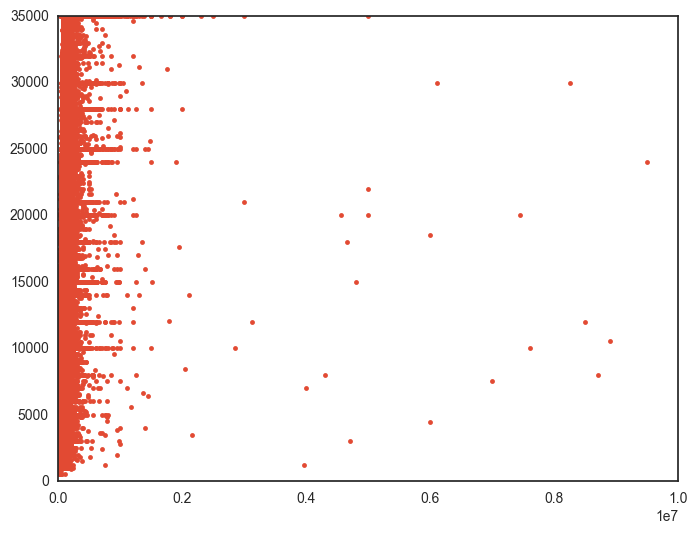

In [6]:
plt.plot(train_data['annual_inc'],train_data['funded_amnt'],'.')
plt.show()

In [7]:
# no of outliers point
total = sum(train_data['annual_inc']>2000000)
total
print(len(train_data))

532428


In [8]:
#removing outliers points
# 30 outliers remove them they will effect our model
train_data = train_data[train_data['annual_inc']<=2000000]
print(len(train_data))

532395


74746.62617263483


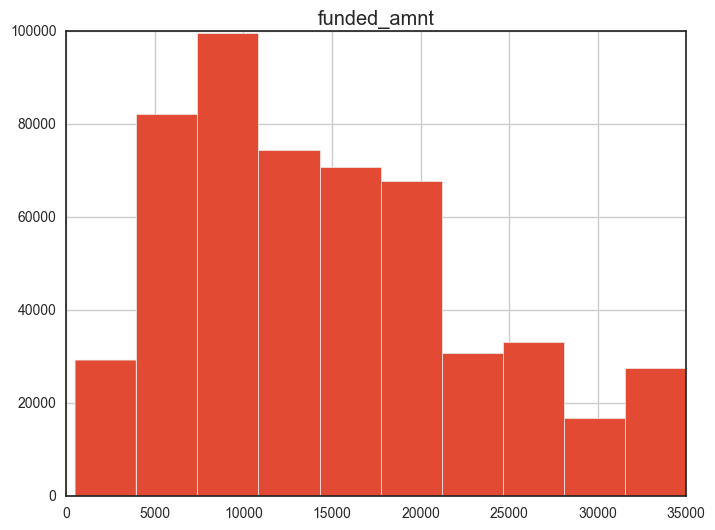

In [9]:
train_data.hist('funded_amnt')
avg_income = train_data['annual_inc'].mean()
print(avg_income)
plt.show()

In [10]:
len(train_data)

532395

In [11]:
# lets add train and test data for data cleaning and feature engineering
loan_data = pd.concat([train_data,test_data])
loan_data.shape

(887346, 45)

In [12]:
loan_data.describe()

C:\Users\Ambar Gupta\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,acc_now_delinq,annual_inc,collection_recovery_fee,collections_12_mths_ex_med,delinq_2yrs,dti,funded_amnt,funded_amnt_inv,inq_last_6mths,int_rate,...,pub_rec,recoveries,revol_bal,revol_util,tot_coll_amt,tot_cur_bal,total_acc,total_rec_int,total_rec_late_fee,total_rev_hi_lim
count,887320.000000,8.873450e+05,887346.000000,887204.000000,887320.000000,887346.000000,887346.000000,887346.000000,887320.000000,887346.000000,...,887320.000000,887346.000000,8.873460e+05,886847.000000,8.170740e+05,8.170740e+05,887320.000000,887346.000000,887346.000000,8.170740e+05
mean,0.004991,7.485766e+04,4.880939,0.014380,0.314438,18.157691,14741.841655,14702.443686,0.694632,13.246840,...,0.195311,45.920951,1.691952e+04,55.067750,2.257095e+02,1.394432e+05,25.268078,1754.836192,0.396690,3.206708e+04
std,0.077627,5.624254e+04,63.126448,0.134193,0.862195,17.190612,8429.823239,8442.012810,0.998457,4.381879,...,0.582098,409.701396,2.240283e+04,23.834082,1.031155e+04,1.534759e+05,11.840537,2095.366359,4.087871,3.748252e+04
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,500.000000,0.000000,0.000000,5.320000,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000,0.000000,0.000000,0.000000e+00
25%,NaN,NaN,0.000000,NaN,NaN,11.910000,8000.000000,8000.000000,NaN,9.990000,...,NaN,0.000000,6.443000e+03,NaN,NaN,NaN,NaN,441.492500,0.000000,NaN
50%,NaN,NaN,0.000000,NaN,NaN,17.660000,13000.000000,13000.000000,NaN,12.990000,...,NaN,0.000000,1.187500e+04,NaN,NaN,NaN,NaN,1073.365000,0.000000,NaN
75%,NaN,NaN,0.000000,NaN,NaN,23.950000,20000.000000,20000.000000,NaN,16.200000,...,NaN,0.000000,2.082900e+04,NaN,NaN,NaN,NaN,2238.350000,0.000000,NaN
max,14.000000,9.000000e+06,7002.190000,20.000000,39.000000,9999.000000,35000.000000,35000.000000,33.000000,28.990000,...,86.000000,33520.270000,2.904836e+06,892.300000,9.152545e+06,4.772549e+06,169.000000,24205.620000,358.680000,9.999999e+06


In [13]:
loan_data.columns

Index(['acc_now_delinq', 'addr_state', 'annual_inc', 'application_type',
       'batch_enrolled', 'collection_recovery_fee',
       'collections_12_mths_ex_med', 'delinq_2yrs', 'desc', 'dti',
       'emp_length', 'emp_title', 'funded_amnt', 'funded_amnt_inv', 'grade',
       'home_ownership', 'initial_list_status', 'inq_last_6mths', 'int_rate',
       'last_week_pay', 'loan_amnt', 'loan_status', 'member_id',
       'mths_since_last_delinq', 'mths_since_last_major_derog',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'purpose',
       'pymnt_plan', 'recoveries', 'revol_bal', 'revol_util', 'sub_grade',
       'term', 'title', 'tot_coll_amt', 'tot_cur_bal', 'total_acc',
       'total_rec_int', 'total_rec_late_fee', 'total_rev_hi_lim',
       'verification_status', 'verification_status_joint', 'zip_code'],
      dtype='object')

In [14]:
# here mean is very low and no of missing values are jsut 26 so we can safely fill 0 to fill na values
loan_data['acc_now_delinq'] = loan_data['acc_now_delinq'].fillna(0)
loan_data['acc_now_delinq'].describe()

count    887346.000000
mean          0.004991
std           0.077626
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          14.000000
Name: acc_now_delinq, dtype: float64

In [15]:
# since addr_state contain many unique values and it doesn't contain any na values
loan_data['addr_state'].describe()

count     887346
unique        51
top           CA
freq      129511
Name: addr_state, dtype: object

In [16]:
#since it has only one muissing value we can fill it with mean value
loan_data['annual_inc'] = loan_data['annual_inc'].fillna(0)
loan_data['annual_inc'].describe()

count    8.873460e+05
mean     7.485758e+04
std      5.624257e+04
min      0.000000e+00
25%      4.500000e+04
50%      6.500000e+04
75%      9.000000e+04
max      9.000000e+06
Name: annual_inc, dtype: float64

In [17]:
loan_data['application_type'].value_counts()

INDIVIDUAL    886835
JOINT            511
Name: application_type, dtype: int64

In [18]:
loan_data['collection_recovery_fee'].describe()

count    887346.000000
mean          4.880939
std          63.126448
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        7002.190000
Name: collection_recovery_fee, dtype: float64

In [19]:
# collection items excluding medical 
# lower the collection item more the chance of approval
loan_data['collections_12_mths_ex_med'] = loan_data['collections_12_mths_ex_med'].fillna(0)
loan_data['collections_12_mths_ex_med'].describe()

count    887346.000000
mean          0.014378
std           0.134182
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          20.000000
Name: collections_12_mths_ex_med, dtype: float64

In [20]:
# delinquence_2 years no of times overdue in past 2 years
loan_data['delinq_2yrs'] = loan_data['delinq_2yrs'].fillna(0)
loan_data['delinq_2yrs'].describe()

count    887346.000000
mean          0.314429
std           0.862184
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          39.000000
Name: delinq_2yrs, dtype: float64

In [21]:
# since description has many unique values we should ignore it
loan_data['desc'].describe()

count                       125777
unique                      116820
top       > Debt consolidation<br>
freq                           958
Name: desc, dtype: object

In [22]:
loan_data['dti'].describe()
# no missing values :)

count    887346.000000
mean         18.157691
std          17.190612
min           0.000000
25%          11.910000
50%          17.660000
75%          23.950000
max        9999.000000
Name: dti, dtype: float64

In [23]:
def update(item):
    s = ''.join(x for x in item if x.isdigit())
    if(len(s)!=0):
        return int(s)
    else:
        return 0

loan_data['emp_length'] = loan_data['emp_length'].apply(lambda x:update(x))   

In [24]:
# A<B<C<D<E<F<G
mapping_dict = {
    "grade":{
        "A": 7,
        "B": 6,
        "C": 5,
        "D": 4,
        "E": 3,
        "F": 2,
        "G": 1
    }
}
loan_data = loan_data.replace(mapping_dict)
loan_data['grade'].head()

0    3
1    6
2    7
3    4
4    6
Name: grade, dtype: int64

In [25]:
loan_data['grade'].value_counts()

6    254524
5    245851
7    148192
4    139539
3     70705
2     23046
1      5489
Name: grade, dtype: int64

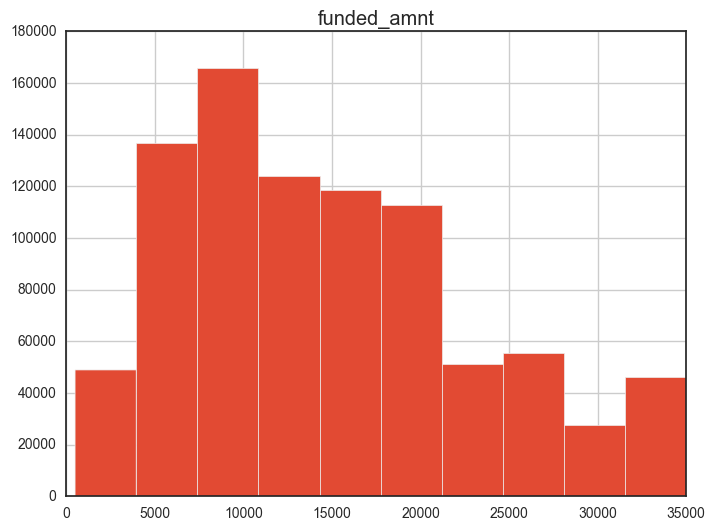

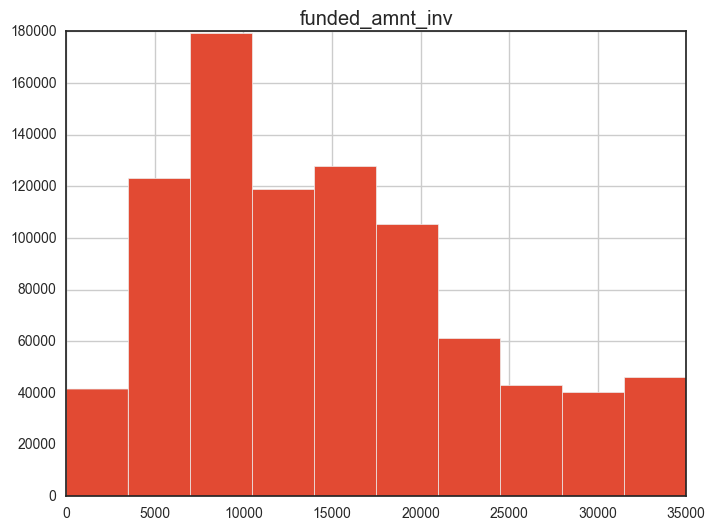

In [26]:
loan_data.hist('funded_amnt')
loan_data.hist('funded_amnt_inv')
plt.show()

In [27]:
loan_data['funded_amnt'].describe()
# no missing values :)

count    887346.000000
mean      14741.841655
std        8429.823239
min         500.000000
25%        8000.000000
50%       13000.000000
75%       20000.000000
max       35000.000000
Name: funded_amnt, dtype: float64

In [28]:
loan_data['initial_list_status'].value_counts()
def update_status(item):
    if item=='f':
        return 0
    else:
        return 1
loan_data['initial_list_status'] = loan_data['initial_list_status'].apply(lambda x:update_status(x))
loan_data['initial_list_status'].head()

0    0
1    1
2    1
3    0
4    1
Name: initial_list_status, dtype: int64

In [29]:
loan_data['inq_last_6mths'].value_counts()
loan_data['inq_last_6mths'] = loan_data['inq_last_6mths'].fillna(0)

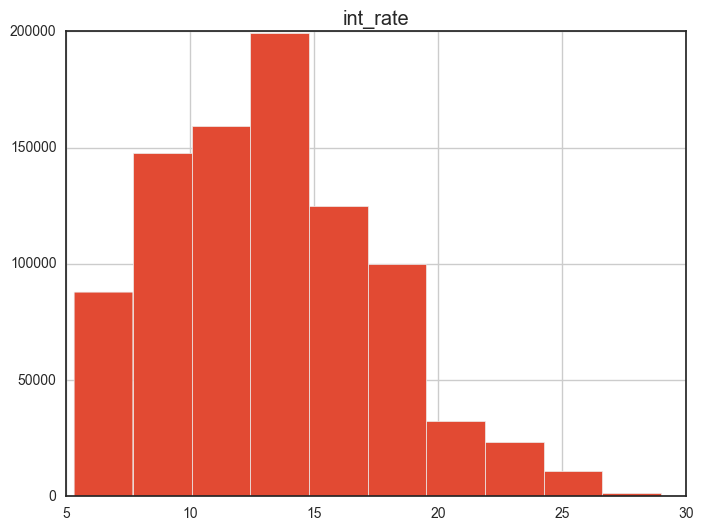

In [30]:
loan_data.hist('int_rate')
plt.show()

In [31]:
loan_data['last_week_pay'].describe()
loan_data['last_week_pay'] = loan_data['last_week_pay'].apply(lambda x:update(x))
loan_data['last_week_pay'].head()

0     26
1      9
2      9
3    135
4     96
Name: last_week_pay, dtype: int64

In [32]:
loan_data['loan_amnt'].describe()

count    887346.000000
mean      14755.229133
std        8435.381496
min         500.000000
25%        8000.000000
50%       13000.000000
75%       20000.000000
max       35000.000000
Name: loan_amnt, dtype: float64

In [33]:
loan_data['loan_status'].describe()

C:\Users\Ambar Gupta\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


count    532395.000000
mean          0.236328
std           0.424827
min           0.000000
25%                NaN
50%                NaN
75%                NaN
max           1.000000
Name: loan_status, dtype: float64

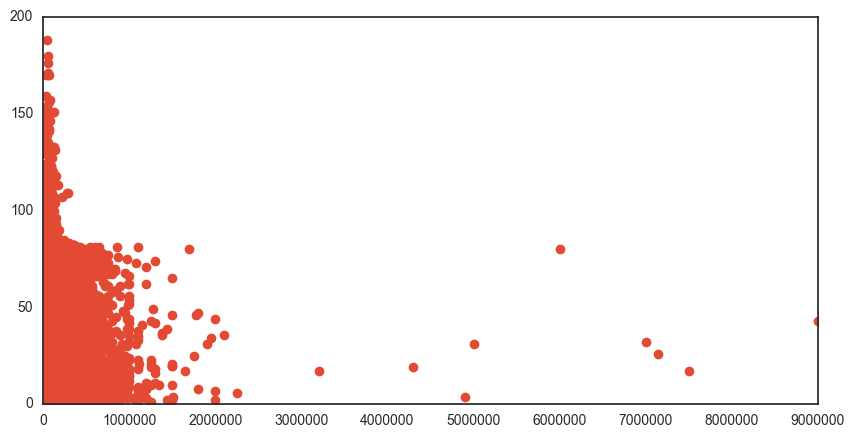

In [34]:
plt.figure(figsize=(10,5))
plt.plot(loan_data['annual_inc'],loan_data['mths_since_last_delinq'],'o')
plt.show()

In [35]:
temp_data = loan_data[loan_data['annual_inc']<=1200000]
m1 = temp_data['mths_since_last_delinq'].mean()
temp_data1 = loan_data[loan_data['annual_inc']>1200000]
m2 = temp_data1['mths_since_last_delinq'].mean()
print(m1,m2)

34.06477076424236 26.571428571428573


In [36]:
loan_data['mths_since_last_delinq'] = loan_data['mths_since_last_delinq'].fillna(34)         

In [37]:
loan_data['mths_since_last_delinq'].head()

0    50.0
1    34.0
2    34.0
3    46.0
4    34.0
Name: mths_since_last_delinq, dtype: float64

In [38]:
loan_data['mths_since_last_record'].describe()

C:\Users\Ambar Gupta\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


count    137049.000000
mean         70.118425
std          28.127641
min           0.000000
25%                NaN
50%                NaN
75%                NaN
max         129.000000
Name: mths_since_last_record, dtype: float64

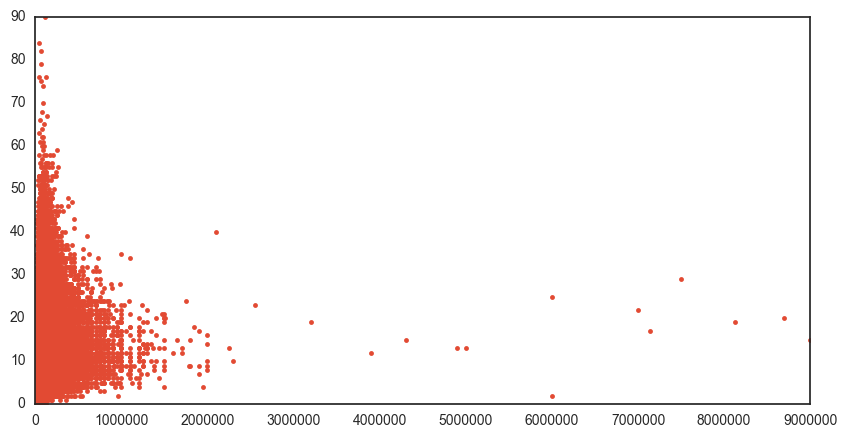

In [39]:
plt.figure(figsize=(10,5))
plt.plot(loan_data['annual_inc'],loan_data['open_acc'],'.')
plt.show()

In [40]:
# no of times borrowed money from credit line type loan 
loan_data['open_acc'] = loan_data['open_acc'].fillna(loan_data['open_acc'].mean())
loan_data['open_acc'].describe()

count    887346.000000
mean         11.548498
std           5.317266
min           0.000000
25%           8.000000
50%          11.000000
75%          14.000000
max          90.000000
Name: open_acc, dtype: float64

In [41]:
#no of derogatory public records
loan_data['pub_rec'] = loan_data['pub_rec'].fillna(0)
loan_data['pub_rec'].describe()

count    887346.000000
mean          0.195305
std           0.582090
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          86.000000
Name: pub_rec, dtype: float64

In [42]:
# total credit lines available in member credit line
loan_data['total_acc'] = loan_data['total_acc'].fillna(loan_data['total_acc'].mean())
loan_data['total_acc'].describe()

count    887346.000000
mean         25.268078
std          11.840364
min           1.000000
25%          17.000000
50%          24.000000
75%          32.000000
max         169.000000
Name: total_acc, dtype: float64

In [43]:
loan_data['recoveries'] = loan_data['recoveries'].fillna(0)
loan_data['recoveries'].describe()

count    887346.000000
mean         45.920951
std         409.701396
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       33520.270000
Name: recoveries, dtype: float64

In [44]:
loan_data['revol_util'] = loan_data['revol_util'].fillna(loan_data['revol_util'].mean())
loan_data['revol_util'].describe()

count    887346.000000
mean         55.067750
std          23.827379
min           0.000000
25%          37.700000
50%          56.000000
75%          73.600000
max         892.300000
Name: revol_util, dtype: float64

In [45]:
loan_data['tot_coll_amt'] = loan_data['tot_coll_amt'].fillna(loan_data['tot_coll_amt'].mean())
loan_data['tot_coll_amt'].describe()

count    8.873460e+05
mean     2.257095e+02
std      9.894825e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.152545e+06
Name: tot_coll_amt, dtype: float64

In [46]:
#total current balance of all accounts
loan_data['tot_cur_bal'] = loan_data['tot_cur_bal'].fillna(loan_data['tot_cur_bal'].mean())
loan_data['tot_cur_bal'].describe()

count    8.873460e+05
mean     1.394432e+05
std      1.472734e+05
min      0.000000e+00
25%      3.224600e+04
50%      1.000865e+05
75%      1.957920e+05
max      4.772549e+06
Name: tot_cur_bal, dtype: float64

In [47]:
# total credit lines available in member credit line
loan_data['total_acc'] = loan_data['total_acc'].fillna(loan_data['total_acc'].mean())
loan_data['total_acc'].describe()

count    887346.000000
mean         25.268078
std          11.840364
min           1.000000
25%          17.000000
50%          24.000000
75%          32.000000
max         169.000000
Name: total_acc, dtype: float64

In [48]:
# revolving card limit
loan_data['total_rev_hi_lim'] = loan_data['total_rev_hi_lim'].fillna(loan_data['total_rev_hi_lim'].mean())
loan_data['total_rev_hi_lim'].describe()

count    8.873460e+05
mean     3.206708e+04
std      3.596773e+04
min      0.000000e+00
25%      1.470000e+04
50%      2.580000e+04
75%      3.780000e+04
max      9.999999e+06
Name: total_rev_hi_lim, dtype: float64

In [49]:
loan_data['verification_status_joint'].describe()

count              511
unique               3
top       Not Verified
freq               283
Name: verification_status_joint, dtype: object

In [50]:
loan_data['zip_code'].describe()

count     887346
unique       935
top        945xx
freq        9770
Name: zip_code, dtype: object

In [51]:
loan_data['annual/loan'] = loan_data['annual_inc']/loan_data['loan_amnt']
loan_data['annual/loan'].head()

0     2.000000
1    13.541667
2     4.500000
3     7.000000
4     3.250000
Name: annual/loan, dtype: float64

In [52]:
loan_data['total_int_latefee'] = loan_data['total_rec_int']+loan_data['total_rec_late_fee']
loan_data['total_int_latefee'].head() 

0    1173.84
1      83.95
2      56.47
3    4858.62
4    2296.41
Name: total_int_latefee, dtype: float64

In [53]:
loan_data['emi'] = loan_data['loan_amnt']*loan_data['int_rate']
loan_data['emi'] = np.sqrt(loan_data['emi'])
loan_data['emi'].head()

0    524.763280
1    229.678036
2    269.443872
3    543.874986
4    412.601503
Name: emi, dtype: float64

In [54]:
loan_data['deliqninq'] = loan_data['delinq_2yrs']*loan_data['inq_last_6mths']
loan_data['deliqninq'].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: deliqninq, dtype: float64

In [55]:
loan_data['open_pub'] = loan_data['open_acc']+loan_data['pub_rec']
loan_data['open_pub'].head()

0    15.0
1     6.0
2     5.0
3    10.0
4    11.0
Name: open_pub, dtype: float64

In [56]:
loan_data['total_rec_fee'] = loan_data['recoveries']+loan_data['collection_recovery_fee']
loan_data['total_rec_fee'].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: total_rec_fee, dtype: float64

In [57]:
loan_data['utilization'] = loan_data['revol_bal']/loan_data['total_rev_hi_lim']
print(loan_data['utilization'].head())
print(loan_data['revol_util'].head())

0    0.731006
1    0.231733
2    0.311662
3    0.555142
4    0.761912
Name: utilization, dtype: float64
0    73.1
1    23.2
2    31.2
3    55.5
4    76.2
Name: revol_util, dtype: float64


In [58]:
loan_data['total_amt'] = loan_data['tot_coll_amt']+loan_data['tot_cur_bal']+loan_data['total_rec_int']-loan_data['total_rec_late_fee']
loan_data['total_amt'].head()

0    29872.84
1    10057.95
2    38416.47
3    60422.62
4    49455.41
Name: total_amt, dtype: float64

# Starting Feature Engineering

In [59]:
loan_data.columns

Index(['acc_now_delinq', 'addr_state', 'annual_inc', 'application_type',
       'batch_enrolled', 'collection_recovery_fee',
       'collections_12_mths_ex_med', 'delinq_2yrs', 'desc', 'dti',
       'emp_length', 'emp_title', 'funded_amnt', 'funded_amnt_inv', 'grade',
       'home_ownership', 'initial_list_status', 'inq_last_6mths', 'int_rate',
       'last_week_pay', 'loan_amnt', 'loan_status', 'member_id',
       'mths_since_last_delinq', 'mths_since_last_major_derog',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'purpose',
       'pymnt_plan', 'recoveries', 'revol_bal', 'revol_util', 'sub_grade',
       'term', 'title', 'tot_coll_amt', 'tot_cur_bal', 'total_acc',
       'total_rec_int', 'total_rec_late_fee', 'total_rev_hi_lim',
       'verification_status', 'verification_status_joint', 'zip_code',
       'annual/loan', 'total_int_latefee', 'emi', 'deliqninq', 'open_pub',
       'total_rec_fee', 'utilization', 'total_amt'],
      dtype='object')

In [60]:
numerical_features = loan_data.select_dtypes(exclude=['object']).columns
categorical_features = loan_data.select_dtypes(include=['object']).columns
print(numerical_features)
print(categorical_features)

Index(['acc_now_delinq', 'annual_inc', 'collection_recovery_fee',
       'collections_12_mths_ex_med', 'delinq_2yrs', 'dti', 'emp_length',
       'funded_amnt', 'funded_amnt_inv', 'grade', 'initial_list_status',
       'inq_last_6mths', 'int_rate', 'last_week_pay', 'loan_amnt',
       'loan_status', 'member_id', 'mths_since_last_delinq',
       'mths_since_last_major_derog', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'recoveries', 'revol_bal', 'revol_util', 'tot_coll_amt',
       'tot_cur_bal', 'total_acc', 'total_rec_int', 'total_rec_late_fee',
       'total_rev_hi_lim', 'annual/loan', 'total_int_latefee', 'emi',
       'deliqninq', 'open_pub', 'total_rec_fee', 'utilization', 'total_amt'],
      dtype='object')
Index(['addr_state', 'application_type', 'batch_enrolled', 'desc', 'emp_title',
       'home_ownership', 'purpose', 'pymnt_plan', 'sub_grade', 'term', 'title',
       'verification_status', 'verification_status_joint', 'zip_code'],
      dtype='object')


In [61]:
selected_num_features = ['acc_now_delinq', 'annual_inc','tot_coll_amt','tot_cur_bal','total_rec_int','total_rec_late_fee',
       'collections_12_mths_ex_med', 'deliqninq', 'dti', 'emp_length',
       'funded_amnt','grade', 'initial_list_status', 'int_rate', 'last_week_pay','mths_since_last_delinq',
        'open_pub','revol_util', 'total_acc','total_amt','emi','annual/loan','total_rec_fee']
selected_cat_features = ['home_ownership','term','verification_status']

# Remove imbalancing from Data

In [62]:
selected_num_features.append('loan_status')
selected_num_features

['acc_now_delinq',
 'annual_inc',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_rec_int',
 'total_rec_late_fee',
 'collections_12_mths_ex_med',
 'deliqninq',
 'dti',
 'emp_length',
 'funded_amnt',
 'grade',
 'initial_list_status',
 'int_rate',
 'last_week_pay',
 'mths_since_last_delinq',
 'open_pub',
 'revol_util',
 'total_acc',
 'total_amt',
 'emi',
 'annual/loan',
 'total_rec_fee',
 'loan_status']

In [63]:
total_features= selected_num_features+selected_cat_features
len(total_features)

27

In [64]:
total_data = loan_data[total_features]
print(total_data.shape)

(887346, 27)


In [65]:
total_data = pd.get_dummies(total_data)
len((total_data.columns.values).tolist())

35

In [66]:
total_data.columns

Index(['acc_now_delinq', 'annual_inc', 'tot_coll_amt', 'tot_cur_bal',
       'total_rec_int', 'total_rec_late_fee', 'collections_12_mths_ex_med',
       'deliqninq', 'dti', 'emp_length', 'funded_amnt', 'grade',
       'initial_list_status', 'int_rate', 'last_week_pay',
       'mths_since_last_delinq', 'open_pub', 'revol_util', 'total_acc',
       'total_amt', 'emi', 'annual/loan', 'total_rec_fee', 'loan_status',
       'home_ownership_ANY', 'home_ownership_MORTGAGE', 'home_ownership_NONE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
       'term_36 months', 'term_60 months', 'verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified'],
      dtype='object')

In [67]:
train_data = total_data[:532395]
temp_data = train_data.sample(frac=0.10)
print(temp_data.shape)
print(train_data.shape)
print(train_data.columns)

(53240, 35)
(532395, 35)
Index(['acc_now_delinq', 'annual_inc', 'tot_coll_amt', 'tot_cur_bal',
       'total_rec_int', 'total_rec_late_fee', 'collections_12_mths_ex_med',
       'deliqninq', 'dti', 'emp_length', 'funded_amnt', 'grade',
       'initial_list_status', 'int_rate', 'last_week_pay',
       'mths_since_last_delinq', 'open_pub', 'revol_util', 'total_acc',
       'total_amt', 'emi', 'annual/loan', 'total_rec_fee', 'loan_status',
       'home_ownership_ANY', 'home_ownership_MORTGAGE', 'home_ownership_NONE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
       'term_36 months', 'term_60 months', 'verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified'],
      dtype='object')


In [68]:
safe_loans = train_data[train_data['loan_status']==0]
print(safe_loans.shape)

(406575, 35)


In [69]:
bad_loans = train_data[train_data['loan_status']==1]
print(bad_loans.shape)

(125820, 35)


In [70]:
safe_fifty = safe_loans.sample(frac=0.062)
safe_fifty.shape

(25208, 35)

In [71]:
bad_fifty = bad_loans.sample(frac=0.20)
bad_fifty.shape

(25164, 35)

In [72]:
balanced_data = pd.concat([safe_fifty,bad_loans])

In [73]:
balanced_data = balanced_data.sample(frac=1.0)
balanced_data['loan_status'].head()

154013    0.0
485427    1.0
450465    0.0
506230    0.0
210818    1.0
Name: loan_status, dtype: float64

In [74]:
train_target = train_data['loan_status']

In [75]:
test_data = total_data[532395:]
test_data = test_data.drop('loan_status',axis=1)

In [76]:
print(test_data.shape)
print(test_data.columns)

(354951, 34)
Index(['acc_now_delinq', 'annual_inc', 'tot_coll_amt', 'tot_cur_bal',
       'total_rec_int', 'total_rec_late_fee', 'collections_12_mths_ex_med',
       'deliqninq', 'dti', 'emp_length', 'funded_amnt', 'grade',
       'initial_list_status', 'int_rate', 'last_week_pay',
       'mths_since_last_delinq', 'open_pub', 'revol_util', 'total_acc',
       'total_amt', 'emi', 'annual/loan', 'total_rec_fee',
       'home_ownership_ANY', 'home_ownership_MORTGAGE', 'home_ownership_NONE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
       'term_36 months', 'term_60 months', 'verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified'],
      dtype='object')


In [77]:
target = 'loan_status'

In [78]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['loan_status'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['loan_status'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['loan_status'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.show()

In [79]:
predictors=[x for x in train_data.columns if x not in ['loan_status']]
print(predictors)

['acc_now_delinq', 'annual_inc', 'tot_coll_amt', 'tot_cur_bal', 'total_rec_int', 'total_rec_late_fee', 'collections_12_mths_ex_med', 'deliqninq', 'dti', 'emp_length', 'funded_amnt', 'grade', 'initial_list_status', 'int_rate', 'last_week_pay', 'mths_since_last_delinq', 'open_pub', 'revol_util', 'total_acc', 'total_amt', 'emi', 'annual/loan', 'total_rec_fee', 'home_ownership_ANY', 'home_ownership_MORTGAGE', 'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT', 'term_36 months', 'term_60 months', 'verification_status_Not Verified', 'verification_status_Source Verified', 'verification_status_Verified']


In [80]:
useful_feature = ['int_rate','last_week_pay','dti','annual_inc','total_rec_late_fee','tot_coll_amt','tot_cur_bal',
                 'emi','annual/loan','revol_util','total_acc','funded_amnt','total_rec_int',
                  'mths_since_last_delinq','open_pub','emp_length','grade','deliqninq','total_amt',
                 'verification_status_Not Verified','verification_status_Source Verified','term_36 months',
                  'verification_status_Verified','home_ownership_RENT','total_rec_fee','term_60 months',
                  'home_ownership_MORTGAGE','home_ownership_OWN']

In [ ]:
xgb1 = XGBClassifier(
 learning_rate =0.3,   
 n_estimators=1000,
 max_depth=6,
 min_child_weight=1,
 gamma=0,
 subsample=1,
 colsample_bytree=1,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, balanced_data, useful_feature)

In [ ]:
print(xgb1.n_estimators,xgb1.learning_rate)
print(xgb1.max_depth)

In [81]:
param_test1 = {
 'max_depth':[3,5,7,9],
 'min_child_weight':[1,3,5]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=1000, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(balanced_data[useful_feature],balanced_data[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.91104, std: 0.00187, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.91133, std: 0.00184, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.91127, std: 0.00160, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.92600, std: 0.00123, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.92595, std: 0.00091, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.92565, std: 0.00127, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.92638, std: 0.00123, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.92631, std: 0.00121, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.92658, std: 0.00145, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.92354, std: 0.00136, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.92391, std: 0.00107, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.92342, std: 0.00096, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 7, 'min_child_weight': 5

In [82]:
param_test2 = {
 'max_depth':[6,7,8],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=1000, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(balanced_data[useful_feature],balanced_data[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.92668, std: 0.00124, params: {'max_depth': 6, 'min_child_weight': 4},
  mean: 0.92672, std: 0.00079, params: {'max_depth': 6, 'min_child_weight': 5},
  mean: 0.92654, std: 0.00157, params: {'max_depth': 6, 'min_child_weight': 6},
  mean: 0.92648, std: 0.00140, params: {'max_depth': 7, 'min_child_weight': 4},
  mean: 0.92658, std: 0.00145, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.92617, std: 0.00164, params: {'max_depth': 7, 'min_child_weight': 6},
  mean: 0.92496, std: 0.00107, params: {'max_depth': 8, 'min_child_weight': 4},
  mean: 0.92495, std: 0.00101, params: {'max_depth': 8, 'min_child_weight': 5},
  mean: 0.92447, std: 0.00113, params: {'max_depth': 8, 'min_child_weight': 6}],
 {'max_depth': 6, 'min_child_weight': 5},
 0.9267162206407601)

In [84]:
param_test3 = {
 'gamma':[i/100.0 for i in range(0,9)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=1000, max_depth=6,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(balanced_data[predictors],balanced_data[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.92722, std: 0.00128, params: {'gamma': 0.0},
  mean: 0.92712, std: 0.00133, params: {'gamma': 0.01},
  mean: 0.92688, std: 0.00126, params: {'gamma': 0.02},
  mean: 0.92708, std: 0.00145, params: {'gamma': 0.03},
  mean: 0.92718, std: 0.00128, params: {'gamma': 0.04},
  mean: 0.92700, std: 0.00127, params: {'gamma': 0.05},
  mean: 0.92705, std: 0.00092, params: {'gamma': 0.06},
  mean: 0.92724, std: 0.00123, params: {'gamma': 0.07},
  mean: 0.92742, std: 0.00132, params: {'gamma': 0.08}],
 {'gamma': 0.08},
 0.9274207989451912)


Model Report
Accuracy : 0.9342
AUC Score (Train): 0.974224


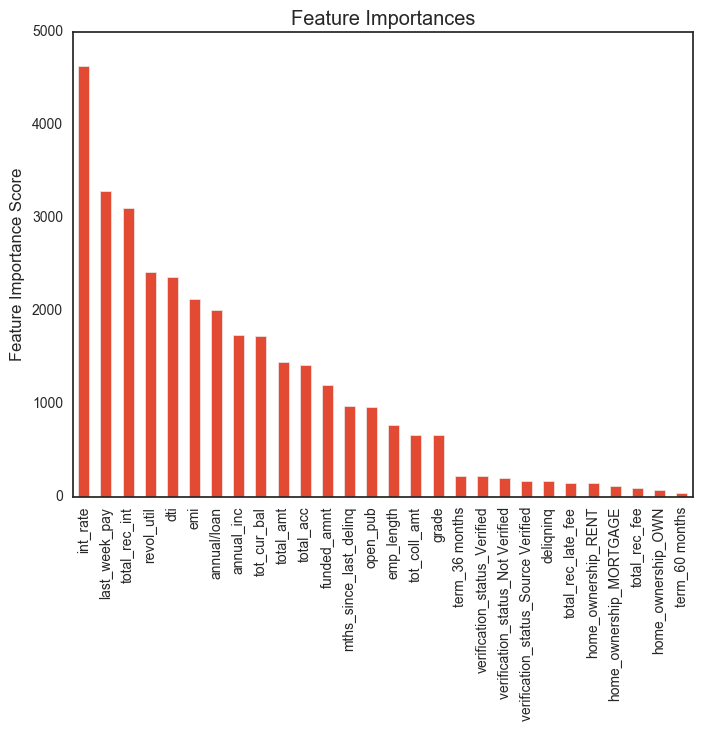

In [87]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=6,
 min_child_weight=5,
 gamma=0.08,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, balanced_data, useful_feature)

In [88]:
print(xgb2.n_estimators,xgb2.learning_rate)
print(xgb2.max_depth)

914 0.1
6


In [89]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=6,
min_child_weight=5, gamma=0.08, subsample=0.8, colsample_bytree=0.8,
objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(balanced_data[useful_feature],balanced_data[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.92104, std: 0.00123, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: 0.92359, std: 0.00107, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: 0.92578, std: 0.00083, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: 0.92823, std: 0.00105, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: 0.92103, std: 0.00165, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: 0.92406, std: 0.00159, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: 0.92639, std: 0.00122, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: 0.92851, std: 0.00150, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: 0.92206, std: 0.00131, params: {'subsample': 0.6, 'colsample_bytree': 0.8},
  mean: 0.92500, std: 0.00100, params: {'subsample': 0.7, 'colsample_bytree': 0.8},
  mean: 0.92660, std: 0.00115, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: 0.92892, std: 0.00129, params: {'subsample': 0.9, 'colsample_bytree'

In [81]:
param_test5 = {
 'subsample':[i/100.0 for i in range(85,100,5)],
 'colsample_bytree':[i/100.0 for i in range(85,100,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=1000, max_depth=6,
 min_child_weight=5, gamma=0.08, subsample=0.9, colsample_bytree=0.9,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(balanced_data[useful_feature],balanced_data[target])
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.92776, std: 0.00157, params: {'colsample_bytree': 0.85, 'subsample': 0.85},
  mean: 0.92856, std: 0.00114, params: {'colsample_bytree': 0.85, 'subsample': 0.9},
  mean: 0.92942, std: 0.00106, params: {'colsample_bytree': 0.85, 'subsample': 0.95},
  mean: 0.92755, std: 0.00127, params: {'colsample_bytree': 0.9, 'subsample': 0.85},
  mean: 0.92838, std: 0.00094, params: {'colsample_bytree': 0.9, 'subsample': 0.9},
  mean: 0.92936, std: 0.00109, params: {'colsample_bytree': 0.9, 'subsample': 0.95},
  mean: 0.92756, std: 0.00172, params: {'colsample_bytree': 0.95, 'subsample': 0.85},
  mean: 0.92848, std: 0.00081, params: {'colsample_bytree': 0.95, 'subsample': 0.9},
  mean: 0.92923, std: 0.00113, params: {'colsample_bytree': 0.95, 'subsample': 0.95}],
 {'colsample_bytree': 0.85, 'subsample': 0.95},
 0.9294247935489139)

#  Tuning Regularization Parameters

In [81]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=1000, max_depth=6,
 min_child_weight=5, gamma=0.08, subsample=0.95, colsample_bytree=0.85,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(balanced_data[useful_feature],balanced_data[target])
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.92827, std: 0.00171, params: {'reg_alpha': 1e-05},
  mean: 0.92875, std: 0.00189, params: {'reg_alpha': 0.01},
  mean: 0.92896, std: 0.00197, params: {'reg_alpha': 0.1},
  mean: 0.92893, std: 0.00162, params: {'reg_alpha': 1},
  mean: 0.88632, std: 0.00192, params: {'reg_alpha': 100}],
 {'reg_alpha': 0.1},
 0.9289558303519785)

In [83]:
param_test7 = {
 'reg_alpha':[0.01,0.0,0.1,0.15,0.2]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=1000, max_depth=6,
 min_child_weight=5, gamma=0.08, subsample=0.95, colsample_bytree=0.85,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(balanced_data[useful_feature],balanced_data[target])
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

([mean: 0.92875, std: 0.00189, params: {'reg_alpha': 0.01},
  mean: 0.92827, std: 0.00171, params: {'reg_alpha': 0.0},
  mean: 0.92896, std: 0.00197, params: {'reg_alpha': 0.1},
  mean: 0.92881, std: 0.00195, params: {'reg_alpha': 0.15},
  mean: 0.92875, std: 0.00178, params: {'reg_alpha': 0.2}],
 {'reg_alpha': 0.1},
 0.9289558303519785)

In [86]:
param_test8 = {
 'reg_alpha':[0.11,0.12,0.13,0.14,0.15]
}
gsearch8 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=1000, max_depth=6,
 min_child_weight=5, gamma=0.08, subsample=0.95,colsample_bytree=0.85,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test8, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch8.fit(balanced_data[useful_feature],balanced_data[target])
gsearch8.grid_scores_, gsearch8.best_params_, gsearch8.best_score_

([mean: 0.92875, std: 0.00180, params: {'reg_alpha': 0.11},
  mean: 0.92881, std: 0.00150, params: {'reg_alpha': 0.12},
  mean: 0.92859, std: 0.00188, params: {'reg_alpha': 0.13},
  mean: 0.92861, std: 0.00191, params: {'reg_alpha': 0.14},
  mean: 0.92881, std: 0.00195, params: {'reg_alpha': 0.15}],
 {'reg_alpha': 0.15},
 0.9288058677964294)


Model Report
Accuracy : 0.9285
AUC Score (Train): 0.970264


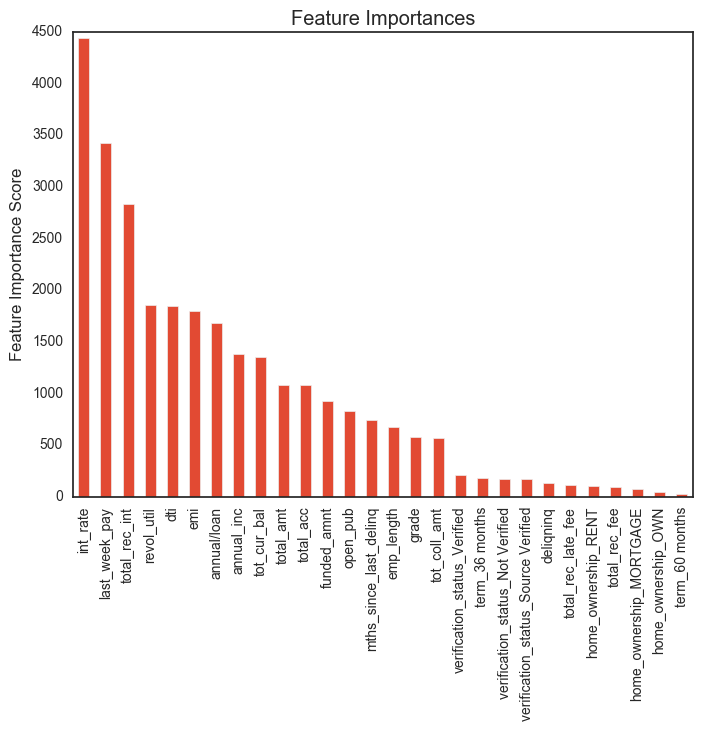

In [81]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=6,
 min_child_weight=5,
 gamma=0.08,
 subsample=0.95,
 colsample_bytree=0.85,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, balanced_data, useful_feature)

In [ ]:
print(xgb3.n_estimators)

# Reducing Learning Rate

In [ ]:
xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=2000,
 max_depth=6,
 min_child_weight=0,
 gamma=0.0,
 subsample=0.95,
 colsample_bytree=0.60,
 reg_alpha=0.15,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, temp_data, predictors)

In [ ]:
safe = np.sum(temp_data['loan_status']==0)
safe

In [ ]:
risky = np.sum(temp_data['loan_status']==1)
risky

In [ ]:
ratio = risky/safe
ratio

In [ ]:
xgb5 = XGBClassifier(
 learning_rate =0.10,
 n_estimators=1000,
 max_depth=6,
 min_child_weight=2,
 gamma=0.1,
 subsample=0.95,
 colsample_bytree=0.60,
 reg_alpha=0.15,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb5, balanced_data, useful_feature)

In [ ]:
param_test9 = {
 'n_estimators':[650,700,750]
}
gsearch9 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=489, max_depth=6,
 min_child_weight=0, gamma=0.0, subsample=0.95, colsample_bytree=0.60,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test9, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch9.fit(temp_data[predictors],temp_data[target])
gsearch9.grid_scores_, gsearch9.best_params_, gsearch9.best_score_

# Gradient Boost Model

In [ ]:
def modelfit1(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['loan_status'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain['loan_status'], cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['loan_status'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['loan_status'], dtrain_predprob))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        plt.show()

In [ ]:
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit1(gbm0, temp_data, predictors)

In [ ]:
param_test1 = {'n_estimators':[325,330,335]}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.2, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(temp_data[predictors],temp_data[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
param_test2 = {'max_depth':list(range(5,16,2)), 'min_samples_split':list(range(200,1001,200))}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.2, n_estimators=330, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(temp_data[predictors],temp_data[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

In [ ]:
param_test3 = {'min_samples_leaf':list(range(30,71,10))}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.2, n_estimators=330,max_depth=7,min_samples_split=800,max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(temp_data[predictors],temp_data[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

In [ ]:
modelfit1(gsearch3.best_estimator_, temp_data, predictors)

In [ ]:
param_test4 = {'max_features':list(range(26,31,2))}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.2, n_estimators=330,max_depth=7, min_samples_split=800, min_samples_leaf=40, subsample=0.8, random_state=10),
param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(temp_data[predictors],temp_data[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

In [ ]:
modelfit1(gsearch4.best_estimator_, temp_data, predictors)

In [ ]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.2, n_estimators=330,max_depth=7,min_samples_split=800, min_samples_leaf=40, subsample=0.8, random_state=10,max_features=26),
param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(temp_data[predictors],temp_data[target])
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

In [ ]:
modelfit1(gsearch5.best_estimator_, temp_data, predictors)

In [ ]:
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.2, n_estimators=330,max_depth=7, min_samples_split=800,min_samples_leaf=40, subsample=0.90, random_state=10, max_features=26)
modelfit1(gbm_tuned_1, balanced_data, useful_feature)

In [ ]:
gbm_tuned_2 = GradientBoostingClassifier(learning_rate=0.02, n_estimators=3300,max_depth=7, min_samples_split=800,min_samples_leaf=40, subsample=0.90, random_state=10, max_features=26)
modelfit1(gbm_tuned_2, temp_data, predictors)

# Logistic Regression

In [ ]:
def modelfit2(alg,dtrain,predictors,cv_folds):
    # cross validation
    cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain['loan_status'], cv=cv_folds, scoring='roc_auc')
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['loan_status'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['loan_status'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['loan_status'], dtrain_predprob))

In [ ]:
lr1 = LogisticRegressionCV(penalty='l2',class_weight='balanced',max_iter=2000,cv=10,random_state=10,solver='sag',tol=1e-4,n_jobs=4)

In [ ]:
modelfit2(lr1,balanced_data,useful_feature,10)

# Writing to CSV

In [ ]:
prediction1 = (xgb5.predict_proba(test_data))[:,1]
prediction1 = prediction1.reshape(len(prediction1),1)
prediction1.shape

In [ ]:
prediction2 = (gbm_tuned_1.predict_proba(test_data))[:,1]
prediction2 = prediction2.reshape(len(prediction2),1)
prediction2.shape

In [ ]:
prediction = prediction1*1.5 + prediction2*1.3
prediction = prediction/2.8
prediction.shape

In [ ]:
test = pd.read_csv('test_indessa.csv')
df= pd.DataFrame()
df['member_id'] = test['member_id']
df['loan_status'] = prediction
df.head()

In [ ]:
df.to_csv('Xgboost.csv',index=False)